# Custom Neural Network using PyTorch models for Fashion MNIST case - Classification

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`

This notebook will use PyTorch by making a simple neural network model. Regardless of model's complexity, creating any model can be completed in a similar way. We will use the **Fashion MNIST** dataset, one of the variants of the MNIST dataset. It has the same property as a normal MNIST, with the same size (28*28) and the same number of classes (10), but the images represent fashion items rather than handwritten digits, which means it might have more complexity than normal MNIST.

Because of its complexity in each class, the problem is slightly more challenging than normal MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST. Moreover, MNIST is overused. In this April 2017 Twitter thread, Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST. In addition, MNIST can not represent modern CV tasks, as noted in this April 2017 Twitter thread, deep learning expert/Keras author François Chollet.

Below is an example of Fashion MNIST. What we will do is to create a simple fully connected network model and check its basic performance on Fashion MNIST.


![alt text](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) from *Zalando Research* data available in github, which has 70,000 article images. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Labels
Each training and test example is assigned to one of the following labels:<br>
0	T-shirt/top<br>
1	Trouser<br>
2	Pullover<br>
3	Dress<br>
4	Coat<br>
5	Sandal<br>
6	Shirt<br>
7	Sneaker<br>
8	Bag<br>
9	Ankle boot

## OUTLINE:

Data pre-processing, plotting and dimensionality reduction, classic ML classification, evaluation.

- Import PyTorch and load a sample dataset
- Sequential fully connected network
- Save the model

### *Library install and dataset load*

You should be able to install PyTorch by using `pip`. You do not need to specify a GPU version.

In [1]:
%%capture
!pip install numpy torch

In [2]:
import torch as pt
import numpy as np

In [3]:
# version?
pt.__version__

'2.8.0+cu126'

We can import the dataset by using `git clone [repo] [folder]` from the URL link

In [4]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


#### Dataset handling: Traditional way with scikit-learn

Some Python modules like `torch` and `tensorflow` have their own easy-to-use versions of standard datasets specialised to the specific library. For a fast, but less general alternative to this tutorial, see [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

If the dataset is hosted on github or similar, the first step is to check the description: [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist#get-the-data)

In [5]:
import os
os.listdir('fashion-mnist/data/fashion')

['t10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz']

Let's load the data:

In [6]:
os.chdir("fashion-mnist")

In [7]:
import utils.mnist_reader as mnist_reader

In [8]:
# load data:

X_train_full, y_train_full = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

This dataset is loaded as a NumPy array. You can use all the methods you learned to check the properties of the dataset, for example **shape** or **describe**.

In [9]:
# Check the type
type(X_train_full)

numpy.ndarray

In [10]:
# Check the shape
X_train_full.shape, X_test.shape

# size of the picture: 28X28 pixels

((60000, 784), (10000, 784))

In [11]:
# Check the unique label

np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

As the dataset is composed of grayscale pixels, the datatype of it is unsigned integer. The dataset also has a pixed range [0, 255] so it does not need to take higher bit than 8. Besides that, PyTorch models are also usually evaluated by one more separate set called validation set as training is an iterative and time-consuming process and we do not know when we need to stop clearly.

In [12]:
# Check the dtype
X_train_full.dtype

dtype('uint8')

To create a validation set, there can be many options, we can explicitly split the dataset using index, or we can just use a training set but with the option stating we want to validate, when we actually fit the model. However, this time we will use scikit-learn's `train_test_split` method to create a validation set as it can provide a nice stratification option.

We need a simple normalization - as we all know the grayscale ranges from 0 to 255...

In [13]:
# To convert the value between 0 and 1 or -1 to 1
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [14]:
X_test = X_test / 255.

### *Train-test split*

In [15]:
from sklearn.model_selection import train_test_split

# Normalize:
X_train_full = X_train_full / 255.

# Split data:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full,
    test_size=0.5, train_size=0.5,
    shuffle=True,
    stratify=y_train_full)
# Stratified to split the target class fairly

In [16]:
# Check the shape

X_train.shape, X_valid.shape

((30000, 784), (30000, 784))

Here we prepared the class names of the fashion MNIST dataset for your convenience.

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [18]:
# Use the numeric label to get the class name, e.g:
class_names[0]

'T-shirt/top'

We can also try to see each data instance by using **plt.imshow**.

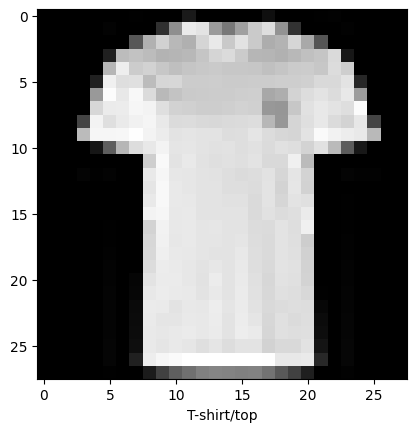

In [19]:
import matplotlib.pyplot as plt
i = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[i].reshape((28, 28)), cmap='gray') # cmap to recognize a grayscale image
plt.xlabel(class_names[y_train[i]])
plt.show()

### *Pipelines: optimizing memory consumption*

Imagine taking the above approach with very large datasets (e.g. used for training modern LLMs). Loading all the data before training would exceed RAM and VRAM of almost any computer.

Therefore, we are going to use the [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) API:

---
***An abstract class representing a Dataset.***

*All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite* `__getitem__()`*, supporting fetching a data sample for a given key. Subclasses could also optionally overwrite* `__len__()`*, which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader. Subclasses could also optionally implement* `__getitems__()`*, for speedup batched samples loading. This method accepts list of indices of samples of batch and returns list of samples.*

---

#### Transform the dataset into a format that you see more often with big datasets.

In [20]:
# unzip data:
target_dir = 'data/data/fashion/unzipped'
os.makedirs(target_dir, exist_ok=True)

train = mnist_reader.load_mnist('data/fashion', kind='train')
t10k  = mnist_reader.load_mnist('data/fashion', kind='t10k')

data = np.concatenate((train[0], t10k[0]), axis=0)
labels = np.concatenate((train[1], t10k[1]), axis=0)

for i, x in enumerate(data):
  file = os.path.join(target_dir, f'img_{i:d}.npy')
  with open(file, 'wb') as f:
    np.save(f, x.reshape((28, 28)))

with open(os.path.join(target_dir, 'labels.npy'), 'wb') as f:
  np.save(f, labels)


# load exactly when needed, stored --> kept in memory as long as needed

In [21]:
os.listdir(target_dir)[:10]

['img_43155.npy',
 'img_64443.npy',
 'img_29816.npy',
 'img_646.npy',
 'img_505.npy',
 'img_13212.npy',
 'img_17499.npy',
 'img_32771.npy',
 'img_36808.npy',
 'img_17134.npy']

In [22]:
labels

array([9, 0, 0, ..., 8, 1, 5], dtype=uint8)

It works like a list of tuples `(X, y)` in Python. Since the data is very huge, we want to optimize the process of unloading data. Therefore, it should load every single sample dynamically from disk when it is requested and this way keep memory consumption to a minimum. Then, we use the variable `target_dir` as the path to the unzipped data.

In [23]:
from numpy.typing import NDArray
from typing import Tuple
from torch.utils.data import Dataset

class FashionMNIST(Dataset):
  def __init__(self, indices:NDArray[np.int32], labels:NDArray[np.int8]) -> None:
    self.indices = indices
    self.labels  = labels

  def __len__(self) -> int:
    return len(self.indices)

  def __getitem__(self, idx:int) -> int:
    # complete

    img_index = int(self.indices[idx])
    file_path = os.path.join(target_dir, f'img_{img_index:d}.npy')
    image = np.load(file_path).astype(np.float32) / 255.0

    return image, self.labels[idx]

  @staticmethod
  def create_split(
      fraction_train:float,
      fraction_validation:float,
      fraction_test:float,
      stratify: bool = True,
      shuffle:bool=True) -> Tuple[Dataset, Dataset, Dataset]:

      assert fraction_train + fraction_validation + fraction_test == 1.0
      # complete

      # load labels only since the image has been saved as .npy in target_dir:
      labels = np.load(os.path.join(target_dir, 'labels.npy'))
      indices = np.arange(len(labels))

      if stratify:

          train_index = []
          valid_index = []
          test_index = []

          for cls in np.unique(labels):
              cls_index = indices[labels == cls]

              if shuffle:
                  cls_index = np.random.permutation(cls_index)

              N = len(cls_index)
              n_train = int(N * fraction_train)
              n_valid = int(N * fraction_validation)

              train_index.append(cls_index[:n_train])
              valid_index.append(cls_index[n_train:n_train + n_valid])
              test_index.append(cls_index[n_train + n_valid:])

          train_index = np.concatenate(train_index, axis=0)
          valid_index = np.concatenate(valid_index, axis=0)
          test_index = np.concatenate(test_index, axis=0)
      else:
          if shuffle:
              indices = np.random.permutation(indices)

          n = len(indices)
          n_train = int(n * fraction_train)
          n_valid = int(n * fraction_validation)

          train_index = indices[:n_train]
          valid_index = indices[n_train:n_train + n_valid]
          test_index = indices[n_train + n_valid:]

      data_train = FashionMNIST(train_index, labels[train_index])
      data_valid = FashionMNIST(valid_index, labels[valid_index])
      data_test  = FashionMNIST(test_index, labels[test_index])

      return data_train, data_valid, data_test

### *Creating the Dataloader*

Our objective is to create a model with the high accuracy on this dataset. Here is our first model!

We use **shuffling and batching**: Using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to easily shuffle and batch the dataset.

In [24]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

In [25]:
data_train, data_valid, data_test = FashionMNIST.create_split(.7, .1, .2)

In [26]:
data_train.indices.shape

(49000,)

In [27]:
loader_train = DataLoader(data_train,             # dataset from which to the dataloader in a batch.
                          batch_size=BATCH_SIZE,  # how many samples per batch to load (default: 1)
                          shuffle=True,           # set to True to have the data reshuffled at every epoch (default: False)
                          sampler=None,           # defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented.
                                                  # If specified, shuffle must not be specified.
                          batch_sampler=None,     # like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.
                          drop_last=False)        # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
                                                  # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

In [28]:
# Validation set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_valid = DataLoader(data_valid,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

In [29]:
# Test set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_test  = DataLoader(data_test,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

### *Sequential fully connected network*

#### Instantiating the network:

The standard way to create a PyTorch model is to override the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) class. To create a model you need to override the following methods:
- `__init__(self, ...) -> None`: Initializes the module and instantiates all the layers and functions.
- `forward(self, x) -> y`: implements the forward pass through the network.

When you create a layer (e.g. [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)), you should specify **in_features** and **out_features**.

Summarization of model parameters is only possible when the model has an input information as it needs to calculate the fully connected parameters from the input layer.

Now we are going to setup a version with the following layers:
- One **linear input layer** of 300 perceptrons, with a **ReLu** activation function, followed by a **dropout** layer (use the `dropout` parameter for the ratio).
- One **linear hidden layers** of size 200, with a **ReLu** activation function, followed by **dropout** layers (use the `dropout` parameter for the ratio).
- One **linear output layer**, with a **softmax** activation function.

Assume that `torch.nn` is already imported as `nn`. Furthermore, `torch.nn.functional` is available as `F`.

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self, dropout:float=.2) -> None:
        super(CustomNetwork, self).__init__()
        #continue
        self.input_layer = nn.Linear(in_features=784, out_features=300, bias=True)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.hidden_layer = nn.Linear(in_features=300, out_features=200, bias=True)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.output_layer = nn.Linear(in_features=200, out_features=len(class_names), bias=True)

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        #continue

        x = x.view(x.size(0), -1) #flatten the input from (batch_size, 28, 28) to (batch_size, 784)
        x = F.relu(self.input_layer(x))
        x = self.dropout_1(x)
        x = F.relu(self.hidden_layer(x))
        x = self.dropout_2(x)
        return F.softmax(self.output_layer(x), dim=-1)

**Alternative but more restrictive:** `torch.nn.Sequential`

In [31]:
from torch.nn import Sequential

Unnamed layers:

In [32]:
model = Sequential(
    nn.Linear(in_features=784, out_features=100, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=len(class_names), bias=True),
    nn.Softmax(dim=-1)
)

In [33]:
from torchsummary import summary

model = CustomNetwork()
summary(model, input_size=(784,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
           Dropout-2                  [-1, 300]               0
            Linear-3                  [-1, 200]          60,200
           Dropout-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


#### Training the Neural Nets

In PyTorch one needs to define which device to use for computation. All tensors involved in the computation need to be on that device. The most common devices are:
- `cpu`: any of your computer's CPUs
- `cpu:0`:the first of your computer's CPUs
- `cuda`: any of your computer's GPUs
- `cuda:2`: the third GPU of you computer

In [34]:
# get gpu if available else cpu:
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
# move a model or tensor to the device:
model = model.to(device)

Prediction on new instances:

In [36]:
X_new = pt.tensor(X_test[:3], dtype=pt.float32, device=device)
y_proba = model(X_new) # this returns a probability?
y_proba = y_proba.detach().cpu().numpy() # to numpy
y_proba

array([[0.09477055, 0.09888439, 0.10155065, 0.10069037, 0.09282348,
        0.09836871, 0.0983526 , 0.10869358, 0.10822622, 0.0976394 ],
       [0.0931158 , 0.08829134, 0.09728904, 0.09886075, 0.10109034,
        0.10450958, 0.10737302, 0.10286103, 0.1098828 , 0.09672629],
       [0.08998017, 0.08827371, 0.10453225, 0.1087819 , 0.09740584,
        0.09480736, 0.09939055, 0.10894965, 0.11203025, 0.09584837]],
      dtype=float32)

In [37]:
np.array(class_names)[np.argmax(y_proba, axis=1)] #if we want to know the class names

array(['Sneaker', 'Bag', 'Bag'], dtype='<U11')

Instances of `torch.nn.Module` have a method `.train()` and a method `.eval()` that set the whole module (including submodules) in a training or prediction mode.

This is necessary, as for example dropout layers are inactive during prediction.

In order to train the network, we need to define a training procedure:

In [38]:
import pandas as pd
from sklearn.metrics import f1_score
from typing import Optional, Callable

How does SGD work?

<img src="https://pantelis.github.io/cs677/docs/common/lectures/optimization/sgd/images/gradient-descent.png" alt="gradient-descent.png" style="width:500px;"/>

Can be improved by:
 - ... reducing the stepsize (i.e. `lr`) towards the end
 - ... using momentum to keep a clear trajectory

The training loop will follow:
1. Utilize basic SGD optimizer with the momentum-based [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer. **As ADAM is more sensitive to the learning rate, set it to `0.001` after changing the optimizer!**
2. Add a [`torch.optim.lr_scheduler.LinearLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html) scheduler (_start: `1.0*lr`, end:`0.33*lr`, over 10 epochs_). Compare how the learning curves change after this step.
3. Add an **early stopping** functionality, that stops training when the validation loss has not improved for `patience` epochs and restores the model parameters to the ones achieving the best loss. **Use a patience of `5` to retrain the network.**

In [39]:
def epoch(model:CustomNetwork, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
  # 1. set model to train:
  model.train()

  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      # move tensors to correct device:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      # reset all gradients to zero:
      optimizer.zero_grad()

      # create predictions:
      y_pred = model(X_batch)

      # calculate loss:
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

      # backpropagate loss:
      loss.backward()

      # update weights:
      optimizer.step()

  return np.mean(losses)

def evaluate(model:CustomNetwork, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None):
  # 1. set model to eval:
  model.eval()

  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    # move tensors to correct device:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    labels.extend(y_batch.cpu().detach().numpy())

    # create predictions:
    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())

    # calculate loss:
    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

  # calculate f1 score:
  f1 = f1_score(
    y_batch.cpu().detach().numpy(),
    y_pred.argmax(dim=1).cpu().detach().numpy(),
    average='macro'
  )

  if loss_fn is None: return {'f1':f1}
  else: return {'loss':np.mean(losses), 'f1':f1}


def fit(model:CustomNetwork, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float, patience:int):
  # instantiate optimizer:
  optimizer = pt.optim.Adam(model.parameters(), lr=lr)

  # instantiate loss function:
  loss_fn = pt.nn.CrossEntropyLoss()

  # add the scheduler
  scheduler = pt.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.33, total_iters=10)

  history = []
  early_stopping = EarlyStopping(patience=patience)

  for i in range(epochs):
    # train for one epoch:
    loss_train = epoch(model, loader_train, optimizer, loss_fn)

    # evaluate on validation:
    metrics = evaluate(model, loader_valid, loss_fn)

    # save metrics:
    history.append({
      'loss_train':loss_train,
      'loss_valid': metrics['loss'],
      'f1_valid': metrics['f1']
    })

    early_stopping.check_early_stop(metrics['loss'], model)
    if early_stopping.stop_training:
        model.load_state_dict(early_stopping.best_state_dict)
        break

    scheduler.step()

  # return history:
  return pd.DataFrame(history)


In [40]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_state_dict = None

    def check_early_stop(self, loss_valid, model):
        if self.best_loss is None or loss_valid < self.best_loss - self.delta:
            self.best_loss = loss_valid
            self.no_improvement_count = 0
            # Save a copy of the model's parameters.
            self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True




<Axes: xlabel='epoch', ylabel='loss'>

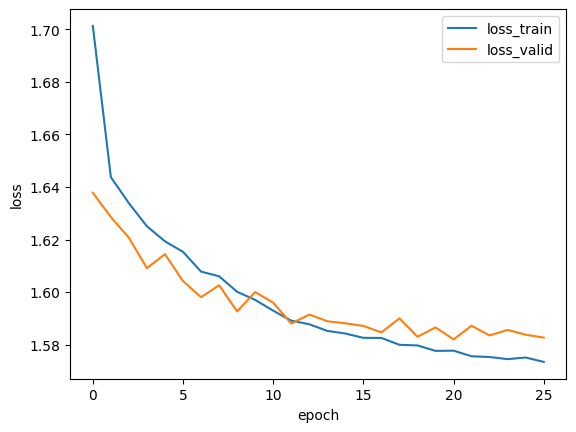

In [41]:
# instantiate model and move to device:
model = CustomNetwork().to(device)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5)

# train model:
history = fit(model, loader_train, loader_valid, epochs=30, lr=0.001, patience=5)

# plot history:
history[['loss_train', 'loss_valid']].plot(xlabel='epoch', ylabel='loss')

**Evaluation**: `evaluate` will return the metric scores!

In [42]:
evaluate(model, loader_test) #evaluate on the test set

{'f1': 0.4838709677419355}

### *Save the model*

**Option 1:** `torch.save(...)` / `torch.load(...)`

In [43]:
pt.save(model, 'model.pt')

In [44]:
# this saves a zipfile!
!unzip model.pt

Archive:  model.pt
replace model/data.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model/.format_version? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/.storage_alignment? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/byteorder? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/data/0? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/data/1? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace model/data/1? [y]es, [n]o, [A]ll, [N]one, [r]ename: none
replace model/data/2? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/data/3? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/data/4? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/data/5? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/version? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace model/.data/serialization_id? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [45]:
model = pt.load('model.pt', weights_only=False) # "weights_only = True" only loads PyTorch Tensors in the model file!
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
           Dropout-2                  [-1, 300]               0
            Linear-3                  [-1, 200]          60,200
           Dropout-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


**Option 2:** save/load state_dict

In [46]:
import pickle

In [47]:
with open('model_state_dict.pkl', 'wb') as f:
  pickle.dump(model.state_dict(), f)

In [48]:
with open('model_state_dict.pkl', 'rb') as f:
  state_dict = pickle.load(f)
model.load_state_dict(state_dict)
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
           Dropout-2                  [-1, 300]               0
            Linear-3                  [-1, 200]          60,200
           Dropout-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


## The End